In [1]:
import mne
from pathlib import Path
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import math
from scipy.io import loadmat
from scipy import signal

In [2]:
base_path1='/Users/zubrikhina/Documents/datasets/EEG_baseline_with_markers/EEG_baseline_Kz_2020/Baseline_Health'
base_path2='/Users/zubrikhina/Documents/datasets/EEG_baseline_with_markers/EEG_baseline_Kz_2020/Baseline_MDD'

In [3]:
sample = mne.io.read_raw_edf(Path(base_path1) /'M118.edf', verbose=False, preload=True)

In [4]:
sample.ch_names

['EEG FP1-R',
 'EEG FP2-R',
 'EEG FPZ-R',
 'EEG F3-R',
 'EEG F4-R',
 'EEG FZ-R',
 'EEG C3-R',
 'EEG C4-R',
 'EEG CZ-R',
 'EEG P3-R',
 'EEG P4-R',
 'EEG PZ-R',
 'EEG O1-R',
 'EEG O2-R',
 'EEG OZ-R',
 'EEG F7-R',
 'EEG F8-R',
 'EEG T3-R',
 'EEG T4-R',
 'EEG T5-R',
 'EEG T6-R']

In [5]:
sample.info

<Info | 7 non-empty values
 bads: []
 ch_names: EEG FP1-R, EEG FP2-R, EEG FPZ-R, EEG F3-R, EEG F4-R, EEG FZ-R, ...
 chs: 21 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 250.0 Hz
 meas_date: 2018-11-19 10:34:19 UTC
 nchan: 21
 projs: []
 sfreq: 500.0 Hz
>

In [6]:
eeg =  sample.to_data_frame()['EEG O1-R'].values

In [54]:
time = sample.to_data_frame()['time'].values

In [55]:
sr = 500
print('Sampling rate = %d samples/sec'%sr)

Sampling rate = 500 samples/sec


In [56]:
time.shape[0]/500

129.0

In [57]:
eeg.shape

(64500,)

In [58]:
time

array([     0,      2,      4, ..., 128994, 128996, 128998])

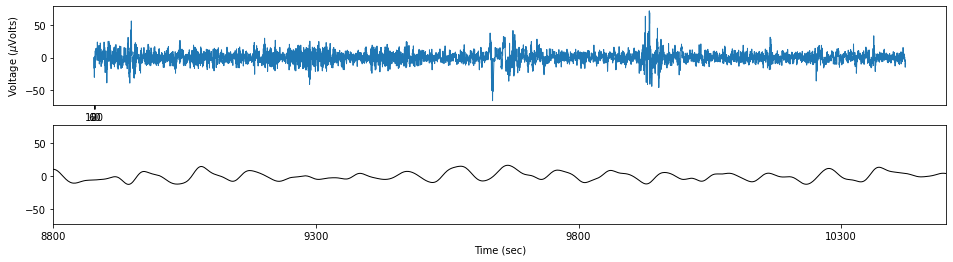

In [59]:
# plot the time course of the EEG
fig, ax = plt.subplots(2,1, figsize=(16,4), sharey=True)

ax[0].plot(time,eeg, lw=1)
ax[0].set_xlabel('Time (sec)'), ax[0].set_ylabel('Voltage ($\mu$Volts)');
ax[0].set_xticks(np.arange(0,130,60));

ax[1].plot(time, eeg, lw=1, color='k')
ax[1].set_xlim(8800,10500)
#ax[1].set_xlim(12,14.5)
ax[1].set_xticks(np.arange(8800,10500,500));
ax[1].set_xlabel('Time (sec)');

In [60]:
np.arange(43,45,1)

array([43, 44])

In [61]:
eeg.size

64500

In [62]:
# Fourier transform
FourierCoeff = np.fft.fft(eeg)/eeg.size
DC = [np.abs(FourierCoeff[0])]
amp = np.concatenate((DC, 2*np.abs(FourierCoeff[1:])))  

# compute frequencies vector until half the sampling rate
Nyquist = sr/2
print('Nyquist frequency = %2.4f Hz'%Nyquist)
Nsamples = int( math.floor(eeg.size/2) )
hz = np.linspace(0, Nyquist, num = Nsamples + 1 )
dhz = hz[1]
print('Spectral resolution = %2.4f Hz'%hz[1])

Nyquist frequency = 250.0000 Hz
Spectral resolution = 0.0078 Hz


In [63]:
sr

500

In [64]:
segment

2000

In [92]:
# Perform Welch's periodogram
segment = int( 4*sr ) 
myhann = signal.get_window('hann', segment)

# obtain the power (uV^2) spectrum with Hann window and 50% overlap
myparams = dict(fs = sr, nperseg = segment, window = myhann, noverlap = segment/2, 
                scaling = 'spectrum', return_onesided = True)
freq, ps = signal.welch(x = eeg, **myparams)# units uV**2
ps = 2*ps

# obtain the power density/Hz (uV^2) spectrum with Hann window and 50% overlap
# to get back to simply power, divide by the segment lenght in seconds (four in our case)
myparams2 = dict(fs = sr, nperseg = segment, window = myhann, noverlap = segment/2, 
                 scaling = 'density', return_onesided = True)
freq, psd = signal.welch(x = eeg, **myparams2)# units uV**2/Hz
psd = 2*psd

dfreq = freq[1]
print('Spectral resolution = %2.4f Hz'%dfreq)

Spectral resolution = 0.2500 Hz


In [95]:
psd.shape

(1001,)

In [66]:
len(hz)

32251

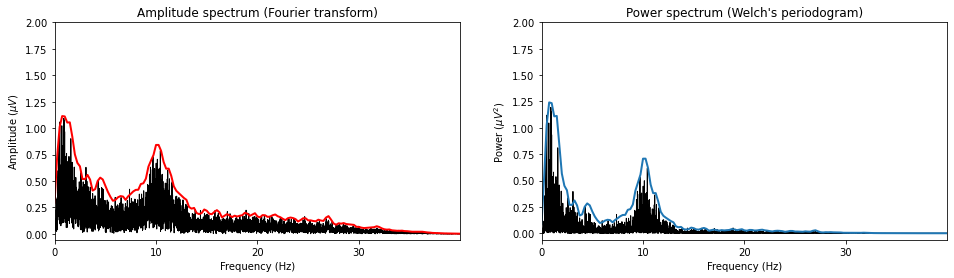

In [67]:
# Plot the power spectrum

fig, ax = plt.subplots(1, 2, figsize=(16, 4))

ax[0].set_title("Amplitude spectrum (Fourier transform)")
ax[0].plot(hz,amp[:len(hz)], lw=1, color='k')#, use_line_collection = True)
ax[0].plot(freq, np.sqrt(ps/10), color='red', lw=2) 
ax[0].set_ylabel('Amplitude ($\mu V$)')

ax[1].set_title("Power spectrum (Welch's periodogram)")
ax[1].plot(hz, np.power(amp[:len(hz)],2), color='k', lw =1)
ax[1].plot(freq, (ps/10), color='C0', lw=2)#, use_line_collection = True)
ax[1].set_ylabel('Power ($\mu V^2$)')

for myax in ax:
    myax.set_xlabel('Frequency (Hz)')
    myax.set_xlim(0,40)
    myticks = list(range(0,40,10))
    myax.set_xticks(myticks)
    myax.set_ylim(ymax=2)

In [75]:
# now we will analyze window lenghts of 500 ms in 25 ms steps. 
# Signals will overlap 475 ms
WinLength = int(0.5*sr) # 500 points (0.5 sec, 500 ms)
step = int(0.25*sr) # 25 points (or 25 ms)

# we have less resolution here because the signals are smaller
Nsamples = int( np.floor(WinLength/2) )
hz = np.linspace(0,Nyquist, Nsamples + 1)
dfreq = hz[1]
print('Spectral resolution = %2.4f Hz'%dfreq)

Spectral resolution = 2.0000 Hz


In [76]:
nsteps = int(np.floor ( (eeg.size - WinLength)/step) )
print(eeg.size, nsteps)

64500 514


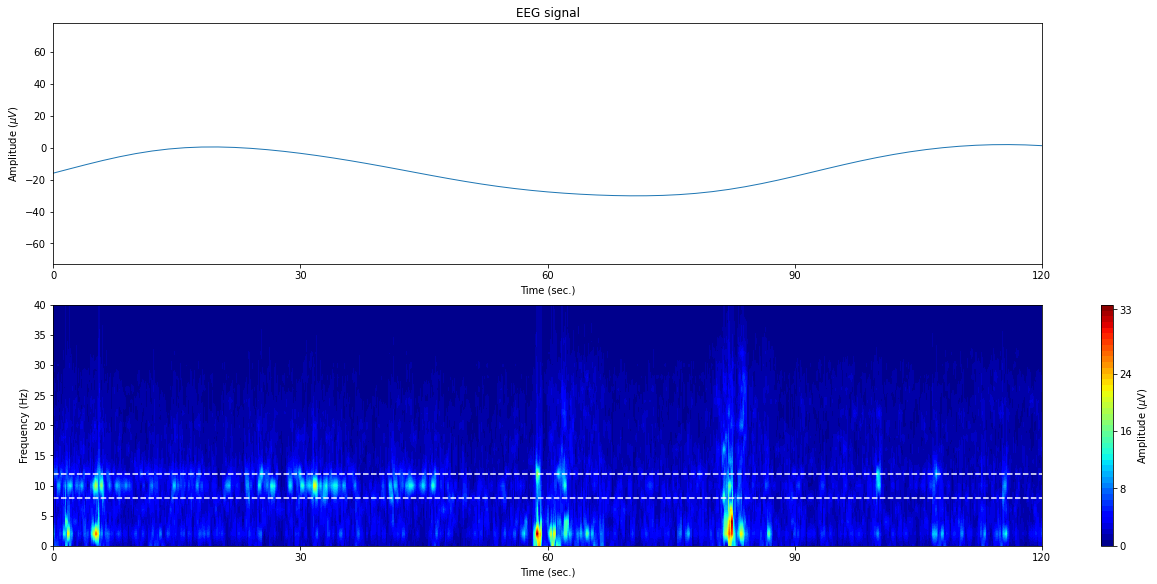

In [70]:
myamp = list()
for i in range(nsteps):
    
    # signal duration 500 ms (512 data points)
    data = eeg[i*step:i*step+WinLength]
    
    FourierCoeff = np.fft.fft(data)/WinLength
    DC = [np.abs(FourierCoeff[0])] # DC component
    amp = np.concatenate((DC, 2*np.abs(FourierCoeff[1:])))
    
    amp = amp[:int(45/dfreq)]
    myamp.append( amp )

power = np.power(myamp, 2)
#logpower = 10*np.log10(power)
fig, ax = plt.subplots(2,1, figsize = (16,8), constrained_layout=True)
#fig.suptitle('Time-frequency power via short-time FFT')

ax[0].plot(time, eeg, lw = 1, color='C0')
ax[0].set_ylabel('Amplitude ($\mu V$)')
ax[0].set_title('EEG signal')

# spectrum is a ContourSet object
dt = 120/nsteps # 120 seconds in number of steps
X = np.arange(nsteps)*dt
Y = hz[:int(45/dfreq)]
Z = np.array(myamp).T
levels = 45
spectrum = ax[1].contourf(X,Y,Z,levels, cmap='jet')#,'linecolor','none')

# get the colormap
cbar = plt.colorbar(spectrum)#, boundaries=np.linspace(0,1,5))
cbar.ax.set_ylabel('Amplitude ($\mu$V)', rotation=90)
cbar.set_ticks(np.arange(0,50,10))

#A working example (for any value range) with five ticks along the bar is:

m0=int(np.floor(np.min(myamp)))            # colorbar min value
m4=int(np.ceil(np.max(myamp)))             # colorbar max value
m1=int(1*(m4-m0)/4.0 + m0)               # colorbar mid value 1
m2=int(2*(m4-m0)/4.0 + m0)               # colorbar mid value 2
m3=int(3*(m4-m0)/4.0 + m0)               # colorbar mid value 3
cbar.set_ticks([m0,m1,m2,m3,m4])
cbar.set_ticklabels([m0,m1,m2,m3,m4])

#cbar.set_ticks(np.arange(0, 1.1, 0.5))

ax[1].axhline(y = 8, linestyle='--', linewidth = 1.5, color='white')
ax[1].axhline(y = 12, linestyle='--', linewidth = 1.5, color='white')
ax[1].set_ylim([0,40])
ax[1].set_yticks(np.arange(0,45,5))
ax[1].set_ylabel('Frequency (Hz)')


for myax in ax:
    myax.set_xlim(0, 120)
    myax.set_xticks(np.arange(0, 121, 30))
    myax.set_xlabel('Time (sec.)')

In [71]:
hz.shape

(126,)

In [91]:
?signal.spectrogram

In [90]:
myparams = dict(nperseg = WinLength, noverlap = None, mode='magnitude')
f, nseg, Sxx = signal.spectrogram(x = eeg, fs = sr, **myparams)

In [86]:
Sxx.shape

(126, 294)

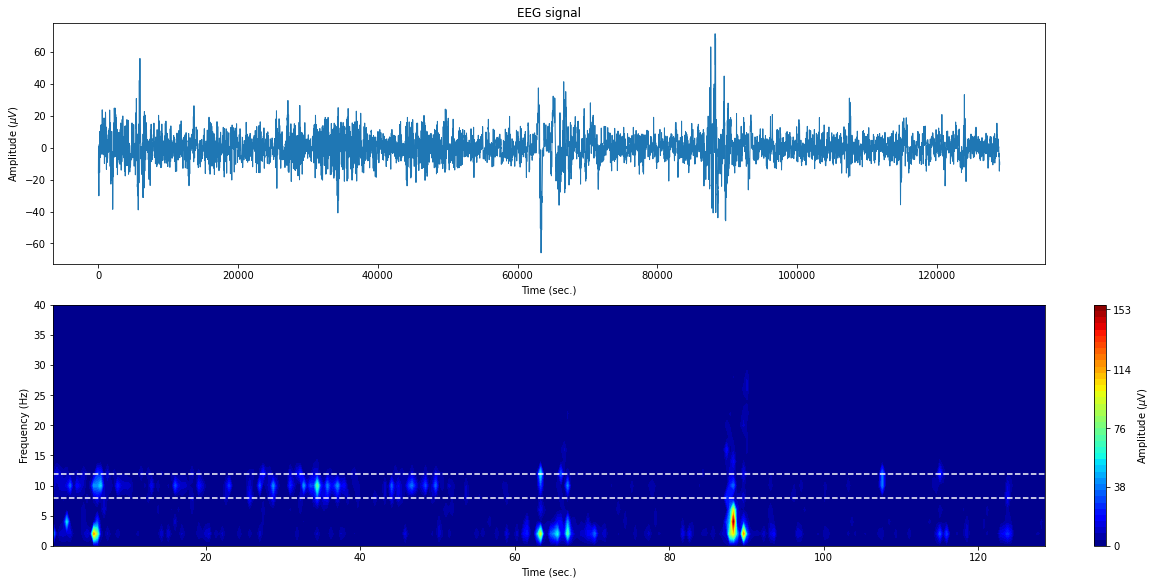

In [87]:
fig, ax = plt.subplots(2,1, figsize = (16,8), constrained_layout=True)

ax[0].plot(time, eeg, lw = 1, color='C0')
ax[0].set_ylabel('Amplitude ($\mu V$)')
ax[0].set_title('EEG signal')

# spectrum is a ContourSet object
dt = 120/nsteps # 120 seconds in number of steps
X = nseg
Y = f
Z = Sxx
levels = 45
spectrum = ax[1].contourf(X,Y,Z,levels, cmap='jet')#,'linecolor','none')

# get the colormap
cbar = plt.colorbar(spectrum)#, boundaries=np.linspace(0,1,5))
cbar.ax.set_ylabel('Amplitude ($\mu$V)', rotation=90)
cbar.set_ticks(np.arange(0,50,10))

#A working example (for any value range) with five ticks along the bar is:

m0=int(np.floor(np.min(Sxx)))            # colorbar min value
m4=int(np.ceil(np.max(Sxx)))             # colorbar max value
m1=int(1*(m4-m0)/4.0 + m0)               # colorbar mid value 1
m2=int(2*(m4-m0)/4.0 + m0)               # colorbar mid value 2
m3=int(3*(m4-m0)/4.0 + m0)               # colorbar mid value 3
cbar.set_ticks([m0,m1,m2,m3,m4])
cbar.set_ticklabels([m0,m1,m2,m3,m4])

#cbar.set_ticks(np.arange(0, 1.1, 0.5))

ax[1].axhline(y = 8, linestyle='--', linewidth = 1.5, color='white')
ax[1].axhline(y = 12, linestyle='--', linewidth = 1.5, color='white')
ax[1].set_ylim([0,40])
ax[1].set_yticks(np.arange(0,45,5))
ax[1].set_ylabel('Frequency (Hz)')


for myax in ax:
    #myax.set_xlim(0, 120)
    #myax.set_xticks(np.arange(0, 121, 30))
    myax.set_xlabel('Time (sec.)')

In [88]:
nseg

array([  0.25 ,   0.688,   1.126,   1.564,   2.002,   2.44 ,   2.878,
         3.316,   3.754,   4.192,   4.63 ,   5.068,   5.506,   5.944,
         6.382,   6.82 ,   7.258,   7.696,   8.134,   8.572,   9.01 ,
         9.448,   9.886,  10.324,  10.762,  11.2  ,  11.638,  12.076,
        12.514,  12.952,  13.39 ,  13.828,  14.266,  14.704,  15.142,
        15.58 ,  16.018,  16.456,  16.894,  17.332,  17.77 ,  18.208,
        18.646,  19.084,  19.522,  19.96 ,  20.398,  20.836,  21.274,
        21.712,  22.15 ,  22.588,  23.026,  23.464,  23.902,  24.34 ,
        24.778,  25.216,  25.654,  26.092,  26.53 ,  26.968,  27.406,
        27.844,  28.282,  28.72 ,  29.158,  29.596,  30.034,  30.472,
        30.91 ,  31.348,  31.786,  32.224,  32.662,  33.1  ,  33.538,
        33.976,  34.414,  34.852,  35.29 ,  35.728,  36.166,  36.604,
        37.042,  37.48 ,  37.918,  38.356,  38.794,  39.232,  39.67 ,
        40.108,  40.546,  40.984,  41.422,  41.86 ,  42.298,  42.736,
        43.174,  43.

In [80]:
Y

array([  0.,   2.,   4.,   6.,   8.,  10.,  12.,  14.,  16.,  18.,  20.,
        22.,  24.,  26.,  28.,  30.,  32.,  34.,  36.,  38.,  40.,  42.,
        44.,  46.,  48.,  50.,  52.,  54.,  56.,  58.,  60.,  62.,  64.,
        66.,  68.,  70.,  72.,  74.,  76.,  78.,  80.,  82.,  84.,  86.,
        88.,  90.,  92.,  94.,  96.,  98., 100., 102., 104., 106., 108.,
       110., 112., 114., 116., 118., 120., 122., 124., 126., 128., 130.,
       132., 134., 136., 138., 140., 142., 144., 146., 148., 150., 152.,
       154., 156., 158., 160., 162., 164., 166., 168., 170., 172., 174.,
       176., 178., 180., 182., 184., 186., 188., 190., 192., 194., 196.,
       198., 200., 202., 204., 206., 208., 210., 212., 214., 216., 218.,
       220., 222., 224., 226., 228., 230., 232., 234., 236., 238., 240.,
       242., 244., 246., 248., 250.])